# H₃⁺ Excited States via Subspace-Search Variational Quantum Eigensolver (SSVQE)

This notebook computes the ground and first excited states of the **Trihydrogen Cation (H₃⁺)** using the **SSVQE** algorithm.

- Molecule: H₃⁺ (Equilateral triangle, 2 electrons)
- Ansatz: UCC-style excitations (singles + doubles)
- Optimizer: Adam
- Goal: Minimize both E₀ and E₁ with orthogonality enforced
- Device: Noiseless statevector simulator

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem
import matplotlib.pyplot as plt
import os
from vqe_utils import excitation_ansatz, get_optimizer, set_seed

set_seed(0)                              # Reproducible runs
IMG_DIR = "images"                       # Single image directory used repo-wide
os.makedirs(IMG_DIR, exist_ok=True)

In [3]:
# Molecular setup:

symbols = ["H", "H", "H"]
coordinates = np.array([
    [0.000000,  1.000000,  0.000000],
    [-0.866025, -0.500000, 0.000000],
    [ 0.866025, -0.500000, 0.000000]
])

hamiltonian, qubits = qchem.molecular_hamiltonian(symbols, coordinates, charge=+1)
electrons = 2
hf = qchem.hf_state(electrons, qubits)

singles, doubles = qchem.excitations(electrons, qubits)
singles = [tuple(x) for x in singles]
doubles = [tuple(x) for x in doubles]
n_params = len(singles) + len(doubles)
num_wires = qubits

In [4]:
# Device and Qnodes:
dev = qml.device("default.qubit", wires=num_wires)


def state_circuit(params):
    excitation_ansatz(params, wires=range(num_wires), hf_state=hf, excitations=(singles, doubles))


@qml.qnode(dev)
def energy_expectation(params):
    state_circuit(params)
    return qml.expval(hamiltonian)


# Overlap function to measure "orthogonality"
@qml.qnode(dev)
def overlap(params1, params2):
    # Prepare |ψ0>
    excitation_ansatz(params1, wires=range(num_wires), hf_state=hf, excitations=(singles, doubles))

    # Apply ⟨ψ1| via adjoint
    qml.adjoint(state_circuit)(params2)

    # Return full probability vector
    return qml.probs(wires=range(num_wires))  # ⟨ψ₀|ψ₁⟩²


# Index the |0...0⟩ component *after* execution
def overlap00(params1, params2):
    return overlap(params1, params2)[0]

In [5]:
# SSVQE cost function
def ssvqe_cost(params):
    p0, p1 = params[:n_params], params[n_params:]
    E0 = energy_expectation(p0)
    E1 = energy_expectation(p1)
    penalty = 10 * overlap00(p0, p1)   # |⟨ψ0|ψ1⟩|^2
    return E0 + E1 + penalty

In [6]:
# Optimization:
params = np.zeros(2 * n_params, requires_grad=True)
opt = get_optimizer("Adam", stepsize=0.4)
max_iter = 75

E0_list, E1_list = [], []

for i in range(max_iter):
    params, cost = opt.step_and_cost(ssvqe_cost, params)

    # Evaluate individual energies
    p0, p1 = params[:n_params], params[n_params:]
    E0 = energy_expectation(p0)
    E1 = energy_expectation(p1)
    
    E0_list.append(E0)
    E1_list.append(E1)

    if i % 10 == 0:
        print(f"Iter {i:02d} | E₀ = {E0:.6f} | E₁ = {E1:.6f}")

Iter 00 | E₀ = -1.230717 | E₁ = -1.230717
Iter 10 | E₀ = -1.262864 | E₁ = -1.262864
Iter 20 | E₀ = -1.002524 | E₁ = -0.734623
Iter 30 | E₀ = -1.050669 | E₁ = -0.055891
Iter 40 | E₀ = -1.213885 | E₁ = -0.411620
Iter 50 | E₀ = -1.241826 | E₁ = -0.507908
Iter 60 | E₀ = -1.255641 | E₁ = -0.523449
Iter 70 | E₀ = -1.265248 | E₁ = -0.557943


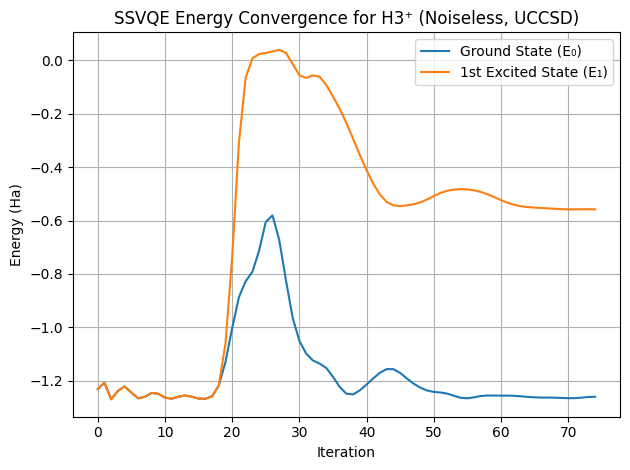

In [7]:
# Energy plots:
plt.plot(E0_list, label="Ground State (E₀)")
plt.plot(E1_list, label="1st Excited State (E₁)")
plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.title("SSVQE Energy Convergence for H3⁺ (Noiseless, UCCSD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{IMG_DIR}/H3+_SSVQE_Adam.png", dpi=300)
plt.show()

In [8]:
# Final state summary:

final_E0 = E0_list[-1]
final_E1 = E1_list[-1]
delta_E = final_E1 - final_E0

print(f"Final Ground State Energy (E₀): {final_E0:.8f} Ha")
print(f"Final Excited State Energy (E₁): {final_E1:.8f} Ha")
print(f"Excitation Energy ΔE = E₁ - E₀: {delta_E:.8f} Ha")

Final Ground State Energy (E₀): -1.25980889 Ha
Final Excited State Energy (E₁): -0.55811374 Ha
Excitation Energy ΔE = E₁ - E₀: 0.70169515 Ha


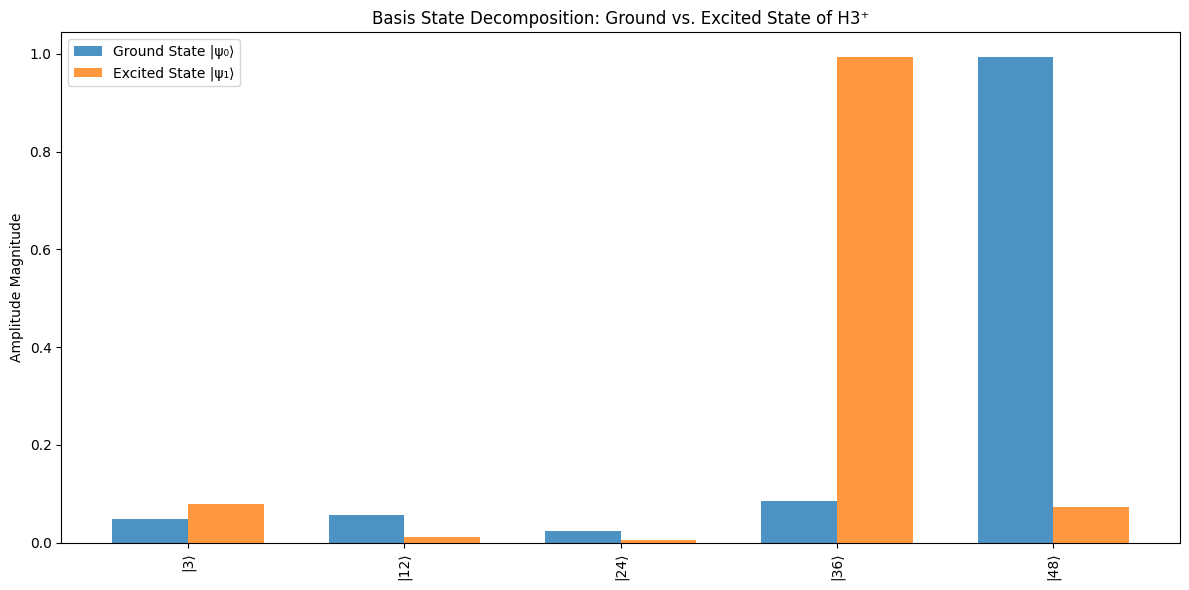

In [9]:
# State comparison/visualization:

@qml.qnode(dev)
def get_state(params):
    excitation_ansatz(params, wires=range(num_wires), hf_state=hf, excitations=(singles, doubles))
    return qml.state()

# Evaluate both final statevectors
psi_0 = get_state(params[:n_params])
psi_1 = get_state(params[n_params:])

# Filter significant amplitudes
threshold = 1e-2

# Indices where either state has non-zero amplitude above threshold
non_zero_indices = np.unique(np.where(
    (np.abs(psi_0) > threshold) | (np.abs(psi_1) > threshold)
)[0])

basis_labels = [f"|{i}⟩" for i in non_zero_indices]   # decimal labels for readability
amp_0 = [np.abs(psi_0[i]) for i in non_zero_indices]
amp_1 = [np.abs(psi_1[i]) for i in non_zero_indices]

# Plot
x = np.arange(len(basis_labels))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, amp_0, width, label='Ground State |ψ₀⟩', alpha=0.8)
plt.bar(x + width/2, amp_1, width, label='Excited State |ψ₁⟩', alpha=0.8)
plt.xticks(x, basis_labels, rotation=90)
plt.ylabel("Amplitude Magnitude")
plt.title("Basis State Decomposition: Ground vs. Excited State of H3⁺")
plt.legend()
plt.tight_layout()
plt.savefig(f"{IMG_DIR}/H3+_SSVQE_State_Comparison.png", dpi=300)
plt.show()